In [26]:
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
from jax import random
from flax.training import train_state
from jax.experimental.ode import odeint

import time

# RELOADING MODULES
import importlib
import neural_net_jaxopt
import matplotlib.pyplot as plt

importlib.reload(neural_net_jaxopt)
ODEOptimizationModelJaxopt = neural_net_jaxopt.ODEOptimizationModelJaxopt

# UTILS DIRECTORY
import sys
import os
collocation2_path = os.path.abspath(os.path.join('..', '00_utils'))

if collocation2_path not in sys.path:
    sys.path.append(collocation2_path)

from collocation import compute_weights, lagrange_derivative

import non_parametric_collocation 
importlib.reload(non_parametric_collocation)
collocate_data = non_parametric_collocation.collocate_data

import data_generation 
importlib.reload(data_generation)
generate_ode_data = data_generation.generate_ode_data

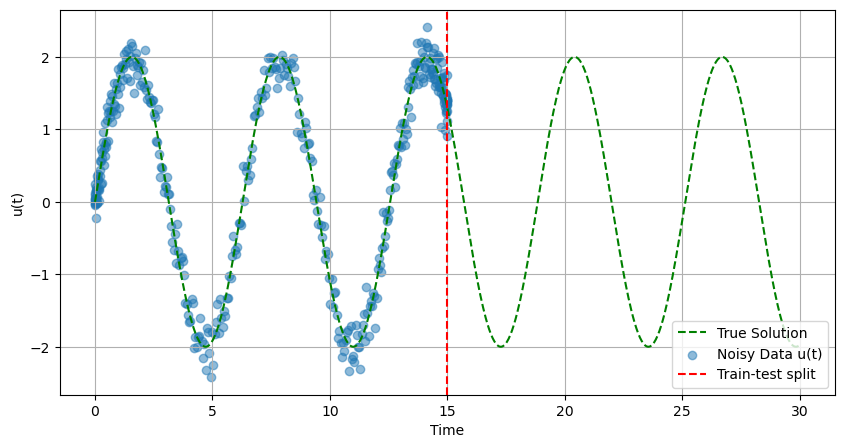

In [14]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 400
noise_level = 0.2
ode_type, params = "sinusoidal_oscillator", {"A": 2}
start_time, end_time = 0, 15
spacing_type = "chebyshev" # "equally_spaced" or "chebyshev"
initial_state = jnp.array([0.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t, y, y_noisy, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy = jnp.array(jnp.squeeze(y_noisy))
t = jnp.array(jnp.squeeze(t))

#-----------------------------------------COLLOCATION MATRIX PREPARATION-------------------------------------------#
weights = compute_weights(t)
D = jnp.array(lagrange_derivative(t, weights))

#---------------------------------------------------TEST DATA--------------------------------------------#
t_test, y_test, _, _ = generate_ode_data(N*2, noise_level, ode_type, params, start_time, end_time*2, "uniform", initial_state)

#--------------------------------------------NON-PARAMETRIC COLLOCATION--------------------------------------------#
estimated_derivative, estimated_solution = collocate_data(y_noisy, t, 'EpanechnikovKernel', bandwidth=0.5)

plt.figure(figsize=(10, 5))
plt.plot(t_test, y_test, 'g--', label='True Solution')
plt.scatter(t, y_noisy.T, label='Noisy Data u(t)', alpha = 0.5)
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=end_time, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

In [18]:
u = jnp.atleast_2d(y_noisy).T
r, c = u.shape
print(f"rows : {r}; columns : {c}")

u_estimated = jnp.atleast_2d(estimated_solution).T
r, c = u_estimated.shape
print(f"rows : {r}; columns : {c}")

rows : 400; columns : 1
rows : 400; columns : 1


In [19]:
type(D)

jaxlib.xla_extension.ArrayImpl

In [20]:
from jax import vmap
from jax.scipy.linalg import block_diag

In [ ]:
y_noisy, t, D = generate_sample_data()

# Define model parameters
layer_sizes = [2, 20, 2] 
penalty_lambda = 1000
smoothing_lambda = 100
max_iter = 1000

model = ODEOptimizationModelJaxopt(y_noisy, t, D, layer_sizes, penalty_lambda=penalty_lambda, smoothing_lambda=smoothing_lambda, max_iter=max_iter)

# Provide some initial guesses for u and v
estimated_solution = jnp.ones((2, len(t)))

init_params = model.initialize_params(estimated_solution[0], estimated_solution[1])
best_params, best_value = model.optimize_model(init_params)

print(f"Best loss value: {best_value}")

# Generate predictions using optimized parameters and initial conditions
initial_conditions = jnp.array([0.0, 1.0])
u_pred, v_pred = model.predict(best_params, t, initial_conditions)

u_opt, v_opt = model.extract_uv_params(best_params)

In [21]:
layer_sizes = [1, 20, 1] 
penalty_lambda = 0.1
smoothing_lambda = 0.0001
max_iter = 500
act_func = "tanh"
w_init_method = "xavier"

neural_ode = NeuralODEJaxopt(
    u, 
    t, D, 
    layer_sizes, 
    penalty_lambda=penalty_lambda, 
    # smoothing_lambda=smoothing_lambda, 
    max_iter=max_iter)

solver_info = neural_ode.solve_model()

predictions = vmap(neural_ode.predict)(t)

# Evaluate the model
mse_loss = neural_ode.mse(y_noisy, predictions)
mae_loss = neural_ode.mae(y_noisy, predictions)

print(f"MSE Loss: {mse_loss}")
print(f"MAE Loss: {mae_loss}")

TypeError: Cannot interpret value of type <class 'neural_net_jaxopt.NeuralODEJaxopt'> as an abstract array; it does not have a dtype attribute

In [22]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.2
ode_type = "harmonic_oscillator"
params = {"omega_squared": 2}
start_time=0
end_time=10
spacing_type="chebyshev"
initial_state = jnp.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t, y, y_noisy, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy = jnp.squeeze(y_noisy)

#---------------------------------------COLLOCATION MATRIX--------------------------------------------#
weights = compute_weights(t)
D = lagrange_derivative(t, weights)

estimated_derivative, estimated_solution = collocate_data(y_noisy, t, 'EpanechnikovKernel', bandwidth=0.5)

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")


In [28]:
y_noisy.shape

(200, 2)

In [27]:
layer_sizes = [2, 20, 2]
penalty_lambda = 1000
smoothing_lambda = 100
max_iter = 1000

model = ODEOptimizationModelJaxopt(y_noisy, t, D, layer_sizes, penalty_lambda=penalty_lambda, smoothing_lambda=smoothing_lambda, max_iter=max_iter)

init_params = model.initialize_params(estimated_solution[0], estimated_solution[1])
best_params, best_value = model.optimize_model(init_params)

print(f"Best loss value: {best_value}")

# Generate predictions using optimized parameters and initial conditions
initial_conditions = jnp.array([0.0, 1.0])
u_pred, v_pred = model.predict(best_params, t, initial_conditions)

u_opt, v_opt = model.extract_uv_params(best_params)

Best loss value: 15.080469277078324
